<a href="https://colab.research.google.com/github/bam098/plant_pathology/blob/main/plant_pathology_basic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True) 

Mounted at /content/drive


In [3]:
!pip uninstall fastai -q -y
!pip install fastai -q

     |████████████████████████████████| 194kB 16.2MB/s 
     |████████████████████████████████| 51kB 6.1MB/s 


In [4]:
import fastai
print(fastai.__version__)

2.1.7


In [26]:
from fastai.vision.all import *
from sklearn.metrics import roc_auc_score

In [6]:
PATH = Path('/content/drive/MyDrive/Colab Notebooks/fastai/Plant Pathology')
DATA_DIR = Path('/content/drive/MyDrive/Colab Notebooks/fastai/Plant Pathology/data')
IMG_DIR = PATH/'data/images'
TRAIN_CSV = 'train.csv'
TEST_CSV = 'test.csv'
SS_CSV = 'sample_submission.csv'


In [7]:
SEED = 42
set_seed(42)
IMG_SIZE = 224
BS = 32
ARCH = resnet18
LR = 1.9e-4 #from lr_finder

In [8]:
DATA_DIR.ls()

(#5) [Path('/content/drive/MyDrive/Colab Notebooks/fastai/Plant Pathology/data/sample_submission.csv'),Path('/content/drive/MyDrive/Colab Notebooks/fastai/Plant Pathology/data/test.csv'),Path('/content/drive/MyDrive/Colab Notebooks/fastai/Plant Pathology/data/train.csv'),Path('/content/drive/MyDrive/Colab Notebooks/fastai/Plant Pathology/data/images'),Path('/content/drive/MyDrive/Colab Notebooks/fastai/Plant Pathology/data/train_with_strat_folds.csv')]

In [9]:
#There are 3642 train and test images in the images folder
(IMG_DIR).ls()

(#3642) [Path('/content/drive/MyDrive/Colab Notebooks/fastai/Plant Pathology/data/images/Train_1724.jpg'),Path('/content/drive/MyDrive/Colab Notebooks/fastai/Plant Pathology/data/images/Train_1732.jpg'),Path('/content/drive/MyDrive/Colab Notebooks/fastai/Plant Pathology/data/images/Train_1698.jpg'),Path('/content/drive/MyDrive/Colab Notebooks/fastai/Plant Pathology/data/images/Train_1710.jpg'),Path('/content/drive/MyDrive/Colab Notebooks/fastai/Plant Pathology/data/images/Train_1703.jpg'),Path('/content/drive/MyDrive/Colab Notebooks/fastai/Plant Pathology/data/images/Train_1731.jpg'),Path('/content/drive/MyDrive/Colab Notebooks/fastai/Plant Pathology/data/images/Train_1773.jpg'),Path('/content/drive/MyDrive/Colab Notebooks/fastai/Plant Pathology/data/images/Train_1769.jpg'),Path('/content/drive/MyDrive/Colab Notebooks/fastai/Plant Pathology/data/images/Train_179.jpg'),Path('/content/drive/MyDrive/Colab Notebooks/fastai/Plant Pathology/data/images/Train_176.jpg')...]

# Understanding the data

In [40]:
#lets take a look at the train csv
train_df = pd.read_csv(DATA_DIR/TRAIN_CSV)
test_df = pd.read_csv(DATA_DIR/TEST_CSV)

In [11]:
#there are 4 classes - multiclass problem
train_df.head(5)

,image_id,healthy,multiple_diseases,rust,scab
0,Train_0,0,0,0,1
1,Train_1,0,1,0,0
2,Train_2,1,0,0,0
3,Train_3,0,0,1,0
4,Train_4,1,0,0,0


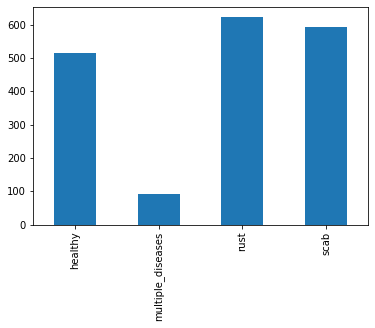

In [12]:
#lets look at the label counts
#lowest count is multiple_disease
LABELS = ['healthy', 'multiple_diseases', 'rust', 'scab']
train_df[LABELS].sum().plot(kind='bar')

In [13]:
#all the other classes except multiple_diseases are about equal. Multiple_diseases is a bit underrepresented
round((train_df[LABELS].sum()/(train_df[LABELS].sum().sum()))*100, 2)

healthy              28.34
multiple_diseases     5.00
rust                 34.16
scab                 32.51
dtype: float64

In [14]:
#total train count
train_df[LABELS].sum().sum()

1821

In [15]:
fn = get_image_files(DATA_DIR/IMG_DIR)[0]
img = PILImage.create(fn)

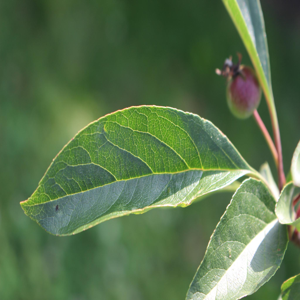

In [16]:
img.resize((300,300))

In [17]:
#lets make a label column
train_df['label'] = train_df[LABELS].idxmax(1)

In [18]:
train_df['label'].value_counts()

rust                 622
scab                 592
healthy              516
multiple_diseases     91
Name: label, dtype: int64

# Data and Dataloader

In [19]:
db = DataBlock(
            blocks=(ImageBlock, CategoryBlock()), 
            getters=[ColReader('image_id', pref=IMG_DIR, suff='.jpg'), ColReader('label')], 
            splitter=RandomSplitter(valid_pct=0.1, seed=SEED),
            item_tfms=Resize(IMG_SIZE),
            batch_tfms=aug_transforms(size=IMG_SIZE, max_rotate=30., min_scale=0.75, flip_vert=True, do_flip=True)
             )

In [20]:
dls = db.dataloaders(source=train_df, bs=BS)

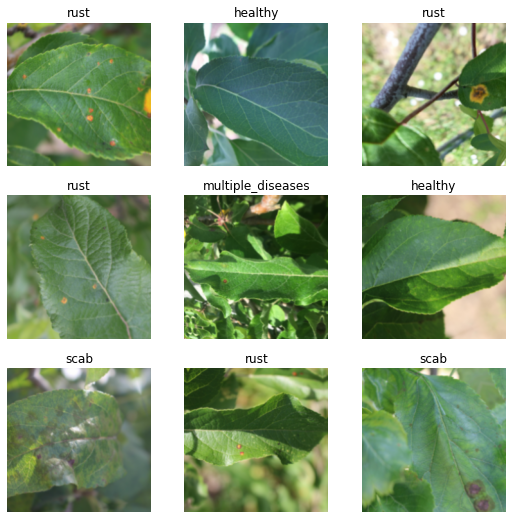

In [21]:
dls.show_batch()

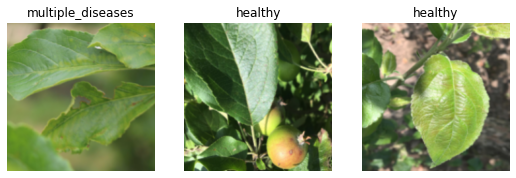

In [22]:
dls.train.show_batch(max_n=3)

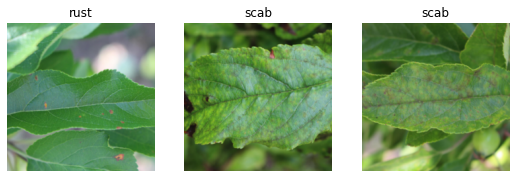

In [23]:
dls.valid.show_batch(max_n=3)

In [24]:
dls.col_reader

(#2) [ColReader -- {'cols': 'image_id', 'pref': Path('/content/drive/MyDrive/Colab Notebooks/fastai/Plant Pathology/data/images'), 'suff': '.jpg', 'label_delim': None}:
encodes: decodes: ,ColReader -- {'cols': 'label', 'pref': '', 'suff': '', 'label_delim': None}:
encodes: decodes: ]

In [25]:
dls.valid.bs

32

# Metric

In [29]:
# the metric was copied from https://www.kaggle.com/lextoumbourou/plant-pathology-2020-eda-training-fastai2?scriptVersionId=33070763

def comp_metric(preds, targs, labels=range(len(LABELS))):
    # One-hot encode targets
    targs = np.eye(4)[targs]
    return np.mean([roc_auc_score(targs[:,i], preds[:,i]) for i in labels])

def healthy_roc_auc(*args):
    return comp_metric(*args, labels=[0])

def multiple_diseases_roc_auc(*args):
    return comp_metric(*args, labels=[1])

def rust_roc_auc(*args):
    return comp_metric(*args, labels=[2])

def scab_roc_auc(*args):
    return comp_metric(*args, labels=[3])

# Training

In [31]:
learn = cnn_learner(dls, ARCH, 
                    loss_func=CrossEntropyLossFlat(),
                    metrics=[accuracy, AccumMetric(comp_metric, flatten=False)]).to_fp16()

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


/usr/local/lib/python3.6/dist-packages/fastai/learner.py:53: UserWarning: Could not load the optimizer state.
  if with_opt: warn("Could not load the optimizer state.")


SuggestedLRs(lr_min=0.025118863582611083, lr_steep=0.004365158267319202)

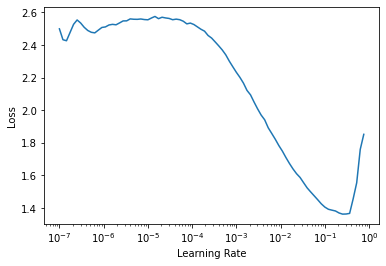

In [ ]:
learn.lr_find()

In [32]:
learn.fine_tune(1, LR)

epoch,train_loss,valid_loss,accuracy,comp_metric,time
0,2.003247,1.027916,0.565934,0.753359,03:51


epoch,train_loss,valid_loss,accuracy,comp_metric,time
0,1.263896,0.760093,0.730769,0.822878,01:23


In [33]:
learn.fit_one_cycle(5, slice(1e-6, LR))

epoch,train_loss,valid_loss,accuracy,comp_metric,time
0,1.020345,0.591446,0.780220,0.861829,01:24
1,0.815597,0.497260,0.818681,0.900975,01:24
2,0.676680,0.443279,0.846154,0.913482,01:25
3,0.601421,0.400410,0.879121,0.920376,01:25
4,0.576055,0.409723,0.862637,0.921567,01:25


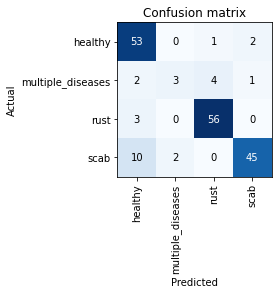

In [34]:
#model is actually missing interp scab as health
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

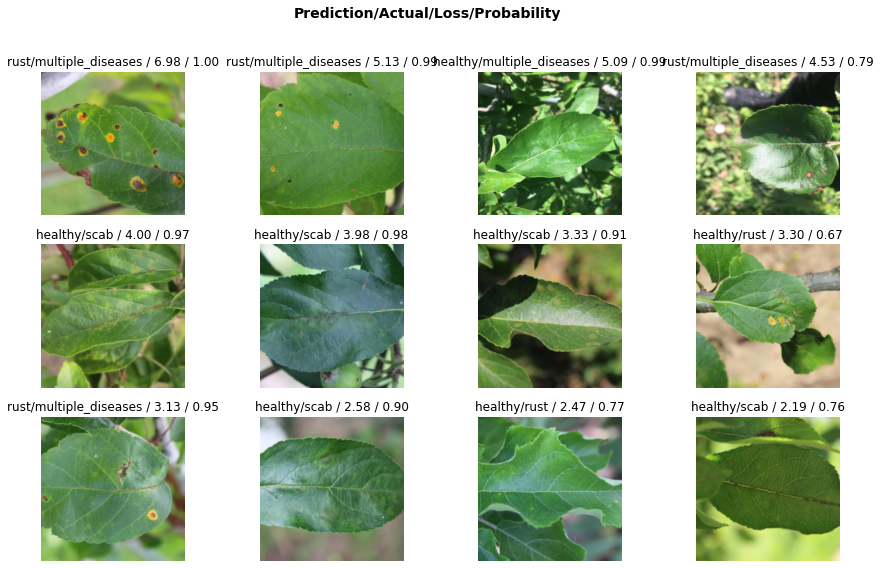

In [63]:
#understandable why multiple_disease looks like rust
interp.plot_top_losses(12, figsize=(15,9), nrows=3)

In [41]:
test_dl = dls.test_dl(test_df)

In [56]:
test_preds, _ = learn.get_preds(dl=test_dl)

In [57]:
sub_df = pd.concat([test_df, pd.DataFrame(test_preds, columns=LABELS)], axis=1)

#interesting concepts used in [this notebook](https://www.kaggle.com/lextoumbourou/plant-pathology-2020-eda-training-fastai2?scriptVersionId=33070763) 

1. multilabel kfold crossvalidation
2. data augmentation (?) - increasing the amount of lowest label data 
3. transfer learning - densenet
4. freeze/unfreeze training
6. LabelSmoothingCrossEntropy
5. to_fp16 - understand this was mentioned in the "bags of tricks for image classification with cnn paper" (anyone has any resources to learn about it)

#other interesting concepts
1. AccumMetric - how does this work?? 

# Things we can try
1. try other (bigger) architecture -->maybe from timm or torchvision
2. other image augmentation
3. factoring the multiple_disease label data by different factors
4. in the above learner, it confuses btw rusty/multiple_disease and scab/healthy (maybe we can look into this also)
